# Train classifier for dry fingerprints on stress, strain, strain rate?

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import h5py
from time import time
#import seaborn as sns
#sns.set_theme(style=None)
# classifiers
from sklearn.ensemble import RandomForestRegressor
#from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPRegressor
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.linear_model import R


## Classification workflow

1. Load dataset
2. Transform to features, if necessary
3. Feature scaling
4. Dimensionality reduction,if necessary
5. Test train split
6. Create classifier
7. Train classifiers with cross fold validation
    - Hyperparameter optimization
8. Evaluate

## Load Data

In [2]:
# fingerprints
with h5py.File('../data/raw/specufex_results.h5', 'r') as file:
    fprints = file['fprints'][:]
    gams = file['gams'][:]
    Vs = file['Vs'][:]

# labels
with h5py.File('../data/raw/allAes.h5','r') as file:
    labels = file['labels'][:]
    sgrams = file['sgrams'][:]
    print(file.keys())

<KeysViewHDF5 ['labels', 'sgrams']>


In [3]:
# labels: 0 - dry, 1 - wet
# first 5471 should be dry - confirm
len(labels) - np.sum(labels)

# But only a subset have mechanical data associated - need to figure that out from dataprep.ipynb
dryAE_cat = pd.read_csv("../data/processed/dryAE_cat.csv")
dry_mechdata = pd.read_csv("../data/processed/dry_events_with_mechdata.csv")

# trim to dry ones only
fprints = fprints[:5471]

In [4]:
#dryAE_cat = dryAE_cat.drop("Unnamed: 0",axis=1)
dryAE_cat.columns = ["orig_index","seconds","event_ID","event_ID_orig"]
dryAE_cat

,orig_index,seconds,event_ID,event_ID_orig
0,0,0,2020.008.393241.142361506,142361506
1,1,1284,2020.008.395405.143645590,143645590
2,2,3196,2020.008.402557.145557856,145557856
3,3,3496,2020.008.403057.145857607,145857607
4,4,4921,2020.008.405442.147282610,147282610
...,...,...,...,...
5466,5466,572745,2020.015.1983826.715106760,715106760
5467,5467,574434,2020.015.1990636.716796490,716796490
5468,5468,574437,2020.015.1990638.716798597,716798597
5469,5469,575584,2020.015.1992545.717945520,717945520


In [5]:
dry_mechdata

,Unnamed: 0,seconds,event_ID,event_ID_orig,t_def,Disp_mm,Sig_diff_MPa,Strain_ax,Temp,events_cumulative
0,51,83176.0,2020.009.623857.225537977,225537977,83176,1.50696,7.6197,0.000184,78.2065,0
1,146,83271.0,2020.009.624033.225633151,225633151,83271,1.53385,10.2866,0.000533,78.1337,1
2,167,83292.0,2020.009.624053.225653637,225653637,83292,1.53809,11.0485,0.000588,78.1701,2
3,292,83417.0,2020.009.624259.225779480,225779480,83417,1.56922,14.8584,0.000992,78.1701,3
4,300,83425.0,2020.009.624307.225787413,225787413,83425,1.57205,15.2394,0.001029,78.2065,4
...,...,...,...,...,...,...,...,...,...,...
5130,416943,572745.0,2020.015.1983826.715106760,715106760,572745,5.18451,105.9138,0.047932,80.6453,5130
5131,418632,574434.0,2020.015.1990636.716796490,716796490,574434,5.18451,105.9138,0.047932,80.6817,5131
5132,418635,574437.0,2020.015.1990638.716798597,716798597,574437,5.18451,105.9138,0.047932,80.7545,5132
5133,419782,575584.0,2020.015.1992545.717945520,717945520,575584,5.18451,105.9138,0.047932,80.6817,5133


In [6]:
events_with_mech_data_index = dry_mechdata.merge(dryAE_cat, left_on="event_ID_orig", right_on="event_ID_orig", how="inner").orig_index.values
events_with_mech_data_index

array([ 105,  106,  107, ..., 5468, 5469, 5470])

In [7]:
#Now can use these index vales to selct the fingerprints that have mechanical data associated

fprints = fprints[events_with_mech_data_index]

In [8]:
# reshape fprints into vector
fprints = fprints.reshape(fprints.shape[0], fprints.shape[1]*fprints.shape[2])
X_scaled = scale(fprints)
y_scaled = scale(dry_mechdata.Strain_ax.values)
y = dry_mechdata.Strain_ax.values

In [9]:
# Split into test and train datasets.
# Train on differential stress first

X_train, X_test, y_train, y_test = train_test_split(X_scaled,y)

In [10]:
names = ["Random Forest", "MLP"]
# MLPClassifier is a multilayer perceptron (fully connected) neural network
#"Nearest Neighbors",
#'MLPClassifier',
classifiers = [
    #KNeighborsClassifier(3),
    RandomForestRegressor(max_depth=100, n_estimators=100, max_features=50),
    MLPRegressor(hidden_layer_sizes=(16,32), alpha=1, max_iter=10000),
    #GaussianNB(),
    #LogisticRegression(max_iter=1000),
    #LogisticRegression(penalty='l1', C=0.01, solver='liblinear')
    ]

fit_classifiers = dict()

for name, clf in zip(names, classifiers):
    t0 = time()
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    clf.fit(X_train, y_train)
    fit_classifiers[name] = clf
    delta_t = time() - t0
    print(f'{name}: validation score: {np.mean(scores)}, test score: {clf.score(X_test, y_test)}, time: {delta_t}')

Random Forest: validation score: 0.0978963156996415, test score: 0.08029708365524246, time: 33.17262887954712
MLP: validation score: 0.06867024493507339, test score: 0.07294286150573981, time: 7.052791118621826


In [11]:
RF = fit_classifiers["Random Forest"]
MLP = fit_classifiers["MLP"]

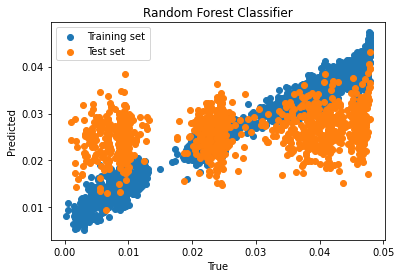

In [12]:
plt.scatter(y_train, RF.predict(X_train), label="Training set")
plt.scatter(y_test, RF.predict(X_test), label="Test set")
plt.legend()
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Random Forest Classifier")
plt.show()

Text(0.5, 1.0, 'Multilayer Perceptron Classifier')

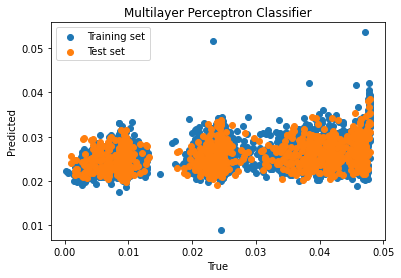

In [13]:
plt.scatter(y_train, MLP.predict(X_train), label="Training set")
plt.scatter(y_test, MLP.predict(X_test), label="Test set")
plt.legend()
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Multilayer Perceptron Classifier")